# Based on:
- https://www.kaggle.com/code/mgmostafa/cmi-best-single-model-simplified/output
- https://www.kaggle.com/code/ichigoe/lb0-494-with-tabnet

# Notes on Successful approaches:
- The best performing public model uses Ensemble learning, specifically a **Voting Regressor**, which combines predictions from LightGBM, XGBoost and CatBoost. "This approach is beneficial as it leverages the strengths of multiple models, reducing overfitting and improving overall model performance."

In [14]:
import numpy as np
import pandas as pd
import os
import re
from typing import List

from scipy import stats
import torch

from imblearn.over_sampling import SMOTE

from sklearn.linear_model import LogisticRegression
from sklearn.base import clone
from sklearn.model_selection import StratifiedKFold
from sklearn.impute import SimpleImputer
# from sklearn.ensemble import VotingRegressor, RandomForestRegressor, GradientBoostingRegressor
from sklearn.impute import SimpleImputer, KNNImputer
# from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.metrics import mean_squared_error, mean_absolute_error, confusion_matrix, cohen_kappa_score
from scipy.stats import randint, uniform
from sklearn.feature_selection import mutual_info_classif
from scipy.optimize import minimize

from concurrent.futures import ThreadPoolExecutor
from tqdm import tqdm
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator, FormatStrFormatter, PercentFormatter
import matplotlib.cm as cm
import seaborn as sns

from colorama import Fore, Style
from IPython.display import clear_output
import warnings
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
from catboost import CatBoostRegressor
# from lightgbm import LGBMClassifier
# from xgboost import XGBClassifier
# from catboost import CatBoostClassifier
from imblearn.over_sampling import SMOTE

warnings.filterwarnings('ignore')
pd.options.display.max_columns = None

In [15]:
def quadratic_weighted_kappa(y_true, y_pred):
    y_pred_rounded = np.round(y_pred).clip(0, 3).astype(int)
    return cohen_kappa_score(y_true, y_pred_rounded, weights='quadratic')

In [16]:
def process_file(filename, dirname):
    df = pd.read_parquet(os.path.join(dirname, filename, 'part-0.parquet'))
    
    # Get basic stats for all cols excpt step
    df.drop('step', axis=1, inplace=True)
    basic_stats = df.describe().values.reshape(-1)
    
    # Add derived features 
    df['hour'] = pd.to_datetime(df['time_of_day']).dt.hour
    df['time_gap'] = pd.to_datetime(df['time_of_day']).diff().dt.total_seconds()
    
    # Define inactivity using all avail info
    enmo_threshold = 0.003
    is_inactive = (
        (df['non-wear_flag'] == 1) |
        (df['enmo'] < enmo_threshold) |
        (df['time_gap'] > 5)
    )
    
    additional_features = [
        (~is_inactive).mean(),  # Activity ratio
        df[df['hour'].between(9, 17)]['enmo'].mean() or 0,  # Daytime activity
        df[~df['hour'].between(9, 17)]['enmo'].mean() or 0,  # Non-daytime activity
        df['time_gap'].gt(5).mean()  # Proportion of large gaps
    ]
    
    features = np.concatenate([basic_stats, additional_features])
    return features, filename.split('=')[1]

def load_time_series(dirname) -> pd.DataFrame:
    ids = os.listdir(dirname)
    
    with ThreadPoolExecutor() as executor:
        results = list(tqdm(
            executor.map(lambda fname: process_file(fname, dirname), ids),
            total=len(ids))
        )
    
    stats, indexes = zip(*results)

    df = pd.DataFrame(stats, columns=[f"Stat_{i}" for i in range(len(stats[0]))])
    df['id'] = indexes
    
    return df

In [17]:
def preprocess_data(df: pd.DataFrame, is_train: bool = False, encoders: dict = None, return_encoders: bool = False) -> pd.DataFrame:
    """Preprocess data including encoding and imputation"""
    df = df.copy()
    
    # handle missing values
    numerical_cols = df.select_dtypes(include=['int64', 'float64']).columns
    for col in numerical_cols:
        df[col] = df[col].fillna(df[col].median())
        
    # Identify cat columns (incl seasons)
    categorical_cols = df.select_dtypes(include=['object']).columns
    
    # Handle missing categoricals
    for col in categorical_cols:
        df[col] = df[col].fillna(df[col].mode()[0])
    
    # Encode categorical 
    if is_train:
        # For training data, create new encoders
        encoders = {}
        for col in categorical_cols:
            if col != 'id':  # Skip ID column
                encoders[col] = LabelEncoder()
                df[col] = encoders[col].fit_transform(df[col])
        # return encoders if specified
        return (df, encoders) if return_encoders else df
    else:
        if encoders is None:
            raise ValueError("Must provide encoders when preprocessing test data")
        # For test data, use provided encoders
        for col in categorical_cols:
            if col != 'id' and col in encoders:  # Skip ID and handle only cols present in train
                df[col] = encoders[col].transform(df[col])
        return df

In [18]:
def find_correlated_features(X, threshold=0.95):
    """Identifies correlated features to remove based on training data"""
    corr_matrix = X.corr().abs()
    upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
    
    # find features to drop
    to_drop = [column for column in upper.columns if any(upper[column] > threshold)]
    print(f"Identified {len(to_drop)} correlated features to remove")
    return to_drop

def remove_correlated_features(X, features_to_drop):
    """Removes specified features from a dataset"""
    X_reduced = X.drop(columns=features_to_drop)
    return X_reduced

# Build Model

In [19]:
# class_weights = {
#     0: 1.0,
#     1: 4.0,  
#     2: 16.0,  
#     3: 32.0  
# }

In [20]:
def get_device_params():
    if torch.cuda.is_available():
        XGB_device = {'tree_method': 'gpu_hist'}
        CB_device = {'task_type': 'GPU'}
        print("GPU detected - using GPU accelerated training")
    else:
        XGB_device = {'tree_method': 'hist'}
        CB_device = {'task_type': 'CPU'}
        print("No GPU detected - using CPU training")
    return XGB_device, CB_device

In [21]:
xgb_device, cb_device = get_device_params()

SEED = 42
n_splits = 5

LGB_Params = {
    'learning_rate': 0.07, 
    'random_state': SEED, 
    'n_estimators': 200,
    'max_depth': 8, 
    'num_leaves': 300, 
    'min_data_in_leaf': 17,
    'feature_fraction': 0.7689, 
    'bagging_fraction': 0.6879, 
    'bagging_freq': 2, 
    'lambda_l1': 4.74, 
    'lambda_l2': 4.743e-06,
    'verbose': -1,
    # 'class_weight': class_weights,
    # 'min_child_samples': 5
}

XGB_Params = {
    'learning_rate': 0.05,
    'max_depth': 6,
    'n_estimators': 200,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'reg_alpha': 1,
    'reg_lambda': 5,
    'random_state': SEED,
    **xgb_device  # This will add either GPU or CPU parameters
}


CatBoost_Params = {
    'learning_rate': 0.05,
    'depth': 6,
    'iterations': 200,
    'random_seed': SEED,
    'verbose': 0,
    'l2_leaf_reg': 15,
    **cb_device  # This will add either GPU or CPU parameters

}

No GPU detected - using CPU training


In [22]:
def analyze_predictions_distribution(y_true, predictions, name=""):
    print(f"\n{'-'*20} {name} Prediction Analysis {'-'*20}")
    
    # Get distribution of predictions
    pred_dist = pd.Series(predictions).value_counts(normalize=True).sort_index() * 100
    
    if y_true is not None:
        # Get distribution of true values
        true_dist = pd.Series(y_true).value_counts(normalize=True).sort_index() * 100
        
        print("\nClass Distribution Comparison:")
        comparison_df = pd.DataFrame({
            'True %': true_dist,
            'Predicted %': pred_dist
        }).round(2)
        print(comparison_df)
        
        # Confusion matrix
        conf_matrix = pd.crosstab(y_true, predictions, 
                                normalize=True) * 100
        print("\nConfusion Matrix (% of true classes predicted as each class):")
        print(conf_matrix.round(2))
        
        # Analysis of severe cases (class 3)
        if 3 in y_true:
            severe_mask = y_true == 3
            severe_predictions = predictions[severe_mask]
            print(f"\nDetailed Analysis of Severe Cases (Class 3):")
            print(f"Total Severe Cases: {sum(severe_mask)}")
            print("Predicted as:")
            for pred_class in range(4):
                count = sum(severe_predictions == pred_class)
                percent = (count / sum(severe_mask)) * 100
                print(f"Class {pred_class}: {count} cases ({percent:.2f}%)")
    else:
        print("\nPrediction Distribution:")
        for class_val, percentage in pred_dist.items():
            print(f"Class {class_val}: {percentage:.2f}%")

In [23]:
def plot_feature_importance(model, feature_names, n_features=20):
    """
    Plot feature importance for LGBM model.
    
    Parameters:
    -----------
    model : LGBMRegressor
        Trained LGBM model
    feature_names : list
        List of feature names
    n_features : int
        Number of top features to display
    """
    # Get feature importance
    importance = model.feature_importances_
    
    # Create DataFrame of features and their importance scores
    feat_importance = pd.DataFrame({
        'Feature': feature_names,
        'Importance': importance
    })
    
    # Sort by importance and get top n features
    feat_importance = feat_importance.sort_values('Importance', ascending=False).head(n_features)
    
    # Create figure with larger size
    plt.figure(figsize=(12, 8))
    
    # Create barplot
    sns.barplot(x='Importance', y='Feature', data=feat_importance)
    
    # Customize plot
    plt.title('Top Feature Importance', fontsize=14, pad=20)
    plt.xlabel('Importance Score', fontsize=12)
    plt.ylabel('Features', fontsize=12)
    
    # Print numeric values
    print("\nTop Feature Importance Values:")
    for _, row in feat_importance.iterrows():
        print(f"{row['Feature']}: {row['Importance']:.4f}")
    
    plt.tight_layout()
    plt.show()
    
    return feat_importance

In [24]:
# Converts continuous predictions into discrete classes
def threshold_Rounder(oof_non_rounded, thresholds):
    return np.where(oof_non_rounded < thresholds[0], 0,
                    np.where(oof_non_rounded < thresholds[1], 1,
                             np.where(oof_non_rounded < thresholds[2], 2, 3)))
def evaluate_predictions(thresholds, y_true, oof_non_rounded):
    rounded_p = threshold_Rounder(oof_non_rounded, thresholds)
    return -quadratic_weighted_kappa(y_true, rounded_p)

In [25]:
# WITH SMOTE
def TrainML(model_class, test_data):

    SKF = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=SEED)
    
    train_S = []
    test_S = []
    
    oof_non_rounded = np.zeros(len(y), dtype=float) 
    oof_rounded = np.zeros(len(y), dtype=int) 
    test_preds = np.zeros((len(test_data), n_splits))

    for fold, (train_idx, test_idx) in enumerate(tqdm(SKF.split(X, y), desc="Training Folds", total=n_splits)):
        X_train, X_val = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_val = y.iloc[train_idx], y.iloc[test_idx]

        # print("Training fold class distribution:")
        # print(y_train.value_counts(normalize=True).sort_index() * 100)
        # print("\nRaw counts:")
        # print(y_train.value_counts().sort_index())

        # smote = SMOTE(random_state=SEED) # basic smote
        
        ## aggresive smote (matching distribution more closely)
        class_counts = y_train.value_counts().sort_index()
        majority_count = class_counts[0]  # count of class 0


        # distribution:
            # 0: 58.3
            # 1: 26.7 # 46 % of majority class
            # 2: 13.8 # 23.7 % of majoriry class
            # 3: 01.2 # 2.05 % of majority class
        
        smote = SMOTE(
            random_state=SEED,
            sampling_strategy={
                # 1: int(majority_count * 0.46),
                # 2: int(majority_count * 0.24),  
                # 3: int(majority_count * 0.021)  
                ##  5.12
                1: int(majority_count * 0.3),  
                2: int(majority_count * 0.2),  
                3: int(majority_count * 0.1)   
                
                # 1: int(majority_count * 0.2),  
                # 2: int(majority_count * 0.3),  
                # 3: int(majority_count * 5)   # 10% of majority class
            }
        )


                      
        X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)
        X_train_resampled = pd.DataFrame(X_train_resampled, columns=X_train.columns)
        
        model = clone(model_class)
        
        # model.fit(X_train, y_train)
        # y_train_pred = model.predict(X_train)
        # y_val_pred = model.predict(X_val)
        model.fit(X_train_resampled, y_train_resampled)
        y_train_pred = np.clip(model.predict(X_train), 0, 3)
        y_val_pred = np.clip(model.predict(X_val), 0, 3)

        oof_non_rounded[test_idx] = y_val_pred
        y_val_pred_rounded = y_val_pred.round(0).astype(int)
        oof_rounded[test_idx] = y_val_pred_rounded

        train_kappa = quadratic_weighted_kappa(y_train, y_train_pred.round(0).astype(int))
        val_kappa = quadratic_weighted_kappa(y_val, y_val_pred_rounded)

        train_S.append(train_kappa)
        test_S.append(val_kappa)
        
        # test_preds[:, fold] = model.predict(test_data)
        test_preds[:, fold] = np.clip(model.predict(test_data), 0, 3)
        
        print(f"Fold {fold+1} - Train QWK: {train_kappa:.4f}, Validation QWK: {val_kappa:.4f}")
        # clear_output(wait=True)

    analyze_predictions_distribution(y, oof_rounded, "OOF")

    print(f"Mean Train QWK --> {np.mean(train_S):.4f}")
    print(f"Mean Validation QWK ---> {np.mean(test_S):.4f}")



    # Use SciPy's minimize() to find best thresholds 
    # to maximize kappa score
    # tries diff thresholds and computes kappa score for each attempt
    # finds thresholds that give highest score
    KappaOPtimizer = minimize(evaluate_predictions,
                              x0=[0.5, 1.5, 2.5], args=(y, oof_non_rounded), 
                              # x0=[0.3, 0.5, 0.6], args=(y, oof_non_rounded), # to increase prob of predicting class 3
                              method='Nelder-Mead') # Nelder-Mead | # Powell
    assert KappaOPtimizer.success, "Optimization did not converge."
    
    oof_tuned = threshold_Rounder(oof_non_rounded, KappaOPtimizer.x)
    tKappa = quadratic_weighted_kappa(y, oof_tuned)

    print(f"----> || Optimized QWK SCORE :: {Fore.CYAN}{Style.BRIGHT} {tKappa:.3f}{Style.RESET_ALL}")

    tpm = test_preds.mean(axis=1)
    tpTuned = threshold_Rounder(tpm, KappaOPtimizer.x)

    # # analyze_predictions_distribution(None, tpTuned, "Ensemble Test")
    if hasattr(model, 'feature_importances_'):
        print("\nAnalyzing Feature Importance...")
        feature_importance_df = plot_feature_importance(model, X.columns)
    
    
    submission = pd.DataFrame({
        'id': test_id,
        'sii': tpTuned
    })

    return submission, model


# Steps for improvement:
- Address class imbalance
    - Modify your StratifiedKFold implementation to ensure the rare class (severity 3) is properly represented in each fold:
    - Add sample weights to give more importance to minority classes:
    - Modify your threshold optimization to be more sensitive to minority classes:
    - Adjust model parameters for imbalanced data:

- Add more new features (look at what other contestants are doing)
- Modify StatifiedKFold to use group-based splitting 
- Consider making model weights adaptive based on validation performance
- Make threshold rounder more robust
- Correlation threshold of 0.95 might be too high

In [26]:
# Load data
print("Loading data...")
try:
    base_path = '/kaggle/input/child-mind-institute-problematic-internet-use'
    train_parquet_path = f'{base_path}/series_train.parquet'
    test_parquet_path = f'{base_path}/series_test.parquet'
    
    train = pd.read_csv(f'{base_path}/train.csv')
    test = pd.read_csv(f'{base_path}/test.csv')
    
    # Get supervised only data (rows with non-null target)
    # train = train[train['sii'].notna()].copy() # REMOVED SINCE I NOW USE KNN
    print(f"Train shape: {train.shape}, Test shape: {test.shape}")
except Exception as e:
    print(f"Error in loading data: {str(e)}")
    raise

Loading data...
Train shape: (3960, 82), Test shape: (20, 59)


In [27]:
print("\nProcessing parquet files...")
try:
    print("Loading and processing training data...")
    train_ts = load_time_series(train_parquet_path)
    print("\nShape of training features:", train_ts.shape)
    
    print("\nLoading and processing test data...")
    test_ts = load_time_series(test_parquet_path)
    print("\nShape of test features:", test_ts.shape)
    
    # Save features
    print("\nSaving features...")
    train_ts.to_parquet("actigraphy_features_train.parquet")
    test_ts.to_parquet("actigraphy_features_test.parquet")
except Exception as e:
    print(f"Error processing parquet files: {str(e)}")
    raise

In [28]:
print("\nLoading parquet data...")
try:
    train_ts = pd.read_parquet("actigraphy_features_train.parquet")
    test_ts = pd.read_parquet("actigraphy_features_test.parquet")
except Exception as e:
    print(f"Error in loading processed parquet data: {str(e)}")
    raise


Loading parquet data...


In [29]:
# Merge parquet features with original data
print("\nMerging parquet data with CSV data...")
try:
    train = pd.merge(train, train_ts, how="left", on='id')
    test = pd.merge(test, test_ts, how="left", on='id')

    print("\nInitial shapes:")
    print("Train combined:", train.shape)
    print("Test combined:", test.shape)
except Exception as e:
    print(f"Error in merging: {str(e)}")
    raise


Merging parquet data with CSV data...

Initial shapes:
Train combined: (3960, 182)
Test combined: (20, 159)


In [30]:
print("\nPreprocessing data (imputation and label encoding)...")
try:
    train, encoders = preprocess_data(train, is_train=True, return_encoders=True)
    test = preprocess_data(test, is_train=False, encoders=encoders)
    
    # Impute using KNN (need to undo line where I remove missing target rows)
    imputer = KNNImputer(n_neighbors=5) # useful since data MAR not MCAR
    numeric_cols = train.select_dtypes(include=['float64', 'int64']).columns
    imputed_data = imputer.fit_transform(train[numeric_cols])
    train_imputed = pd.DataFrame(imputed_data, columns=numeric_cols)
    train_imputed['sii'] = train_imputed['sii'].round().astype(int)
    for col in train.columns:
        if col not in numeric_cols:
            train_imputed[col] = train[col]
    train = train_imputed
        
except Exception as e:
    print(f"Error in preprocessing: {str(e)}")
    raise


Preprocessing data (imputation and label encoding)...


In [31]:
print("\nLast Prep for Training...")
try:
    exclude_patterns = ['id', 'PCIAT', 'sii']
    feature_cols = [col for col in train.columns 
                   if not any(pattern in col for pattern in exclude_patterns)]
    X = train[feature_cols]
    y = train['sii']
    features_to_drop = find_correlated_features(X, threshold=0.95) 
    X = remove_correlated_features(X, features_to_drop)
    
    test_id = test['id'].copy()
    test = test[feature_cols]
    test = remove_correlated_features(test, features_to_drop)
except Exception as e:
    print()
    raise


Last Prep for Training...
Identified 40 correlated features to remove


In [32]:
train.shape

(3960, 182)


Training models...


Training Folds:  20%|██        | 1/5 [00:01<00:05,  1.31s/it]

Fold 1 - Train QWK: 0.8287, Validation QWK: 0.4751


Training Folds:  40%|████      | 2/5 [00:02<00:04,  1.38s/it]

Fold 2 - Train QWK: 0.8371, Validation QWK: 0.4716


Training Folds:  60%|██████    | 3/5 [00:03<00:02,  1.31s/it]

Fold 3 - Train QWK: 0.8336, Validation QWK: 0.5036


Training Folds:  80%|████████  | 4/5 [00:05<00:01,  1.29s/it]

Fold 4 - Train QWK: 0.8331, Validation QWK: 0.4387


Training Folds: 100%|██████████| 5/5 [00:06<00:00,  1.29s/it]

Fold 5 - Train QWK: 0.8376, Validation QWK: 0.3997

-------------------- OOF Prediction Analysis --------------------

Class Distribution Comparison:
     True %  Predicted %
0.0   71.16        64.75
1.0   18.43        32.93
2.0    9.55         2.30
3.0    0.86         0.03

Confusion Matrix (% of true classes predicted as each class):
col_0      0      1     2     3
sii                            
0.0    56.11  14.52  0.53  0.00
1.0     6.52  11.26  0.66  0.00
2.0     2.12   6.57  0.83  0.03
3.0     0.00   0.58  0.28  0.00

Detailed Analysis of Severe Cases (Class 3):
Total Severe Cases: 34
Predicted as:
Class 0: 0 cases (0.00%)
Class 1: 23 cases (67.65%)
Class 2: 11 cases (32.35%)
Class 3: 0 cases (0.00%)
Mean Train QWK --> 0.8340
Mean Validation QWK ---> 0.4578


----> || Optimized QWK SCORE ::  0.512

Analyzing Feature Importance...

Top Feature Importance Values:
SDS-SDS_Total_Raw: 404.0000
Physical-BMI: 332.0000
Physical-Height: 319.0000
Physical-HeartRate: 318.0000
Physical-Weight: 310.0000
Physical-Systolic_BP: 310.0000
CGAS-CGAS_Score: 304.0000
Physical-Diastolic_BP: 274.0000
BIA-BIA_BMC: 270.0000
PAQ_C-PAQ_C_Total: 264.0000
FGC-FGC_CU: 232.0000
BIA-BIA_FMI: 214.0000
Basic_Demos-Age: 172.0000
PreInt_EduHx-computerinternet_hoursday: 172.0000
FGC-FGC_TL: 171.0000
BIA-BIA_FFMI: 171.0000
FGC-FGC_SRR: 162.0000
FGC-FGC_SRL: 136.0000
FGC-FGC_PU: 129.0000
FGC-FGC_GSD: 124.0000


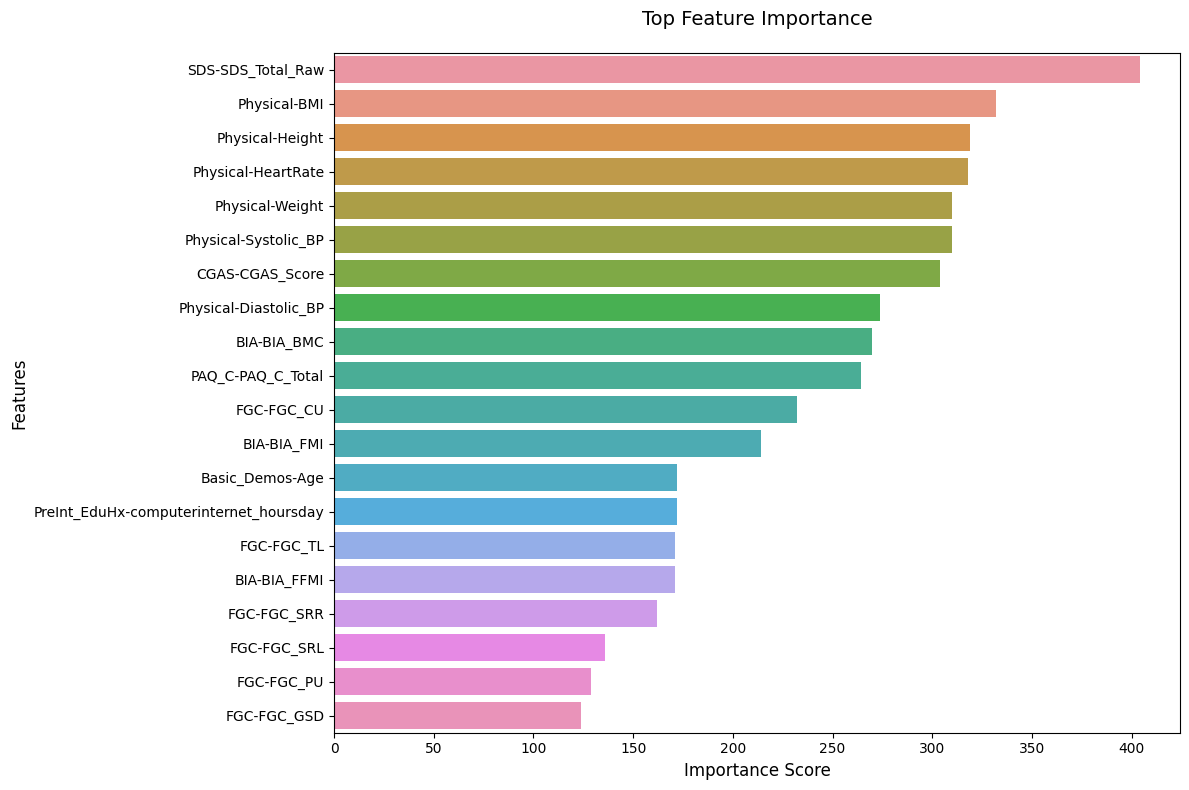


Saving submission...
Done!


In [33]:
print("\nTraining models...")
try:
    models = LGBMRegressor(**LGB_Params)
    # models = CatBoostRegressor(**CatBoost_Params)
    # models = XGBRegressor(**XGB_Params)
    # models = {
        # 'lgbm': LGBMRegressor(**LGB_Params),
        # 'xgboost': XGBRegressor(**XGB_Params),
        # 'catboost': CatBoostRegressor(**CatBoost_Params)
    # }
    # ensemble_submission, scores, weights = weighted_ensemble_train(X, y, test_features, models)
    submission, trained_model = TrainML(models, test)
except Exception as e:
    print(f"Error in model training: {str(e)}")
    raise

# Save submission
print("\nSaving submission...")
# ensemble_submission.to_csv('submission.csv', index=False)
submission.to_csv('submission.csv', index=False)

print("Done!")